In [9]:
import sys
sys.path.insert(1,'../src')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()


tfk = tf.keras
tfkl = tf.keras.layers

import util
import GA_util
import time
import nupack as n
mod = n.Model()


print('loaded')

loaded


In [10]:
predictor = tf.keras.models.load_model('../models/valeri_predictor')
predictor.summary()

Model: "valeri_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 59, 4)]      0           []                               
                                                                                                  
 conv1d_6 (Conv1D)              (None, 59, 10)       210         ['input_8[0][0]']                
                                                                                                  
 conv1d_7 (Conv1D)              (None, 59, 5)        155         ['conv1d_6[0][0]']               
                                                                                                  
 flatten_7 (Flatten)            (None, 295)          0           ['conv1d_7[0][0]']               
                                                                                       

In [11]:
#Helper functions for activaiton maximization using the transposed sequence format found in the Valeri et al. Paper

def create_rand_valeri_inputs(n_seqs):
    out = np.zeros(shape=(n_seqs,59,4))
    for i in range(n_seqs):
        for j in range(59):
            nt = GA_util.get_random_nt()
            out[i,j,GA_util.nucleotides[nt]] = 1
    return out

def unencode_valeri(sequence):
    out = ''
    # print(sequence.shape)
    for i in range(sequence.shape[0]):
        
        val = np.argmax(sequence[i,:])
        out += GA_util.letters[val]
    return out  


x = create_rand_valeri_inputs(5)
# print(x)
print(unencode_valeri(x[0,:,:]))

TGAGTGGTACAAGCGCACCTCACAGCTTCCCAGCATCCTCCGGGGCTAATTAATTATGT


In [12]:
def constrained_rand_valeri_inputs(n_seqs):
    #here we are providing the start codon and RBS to the random input
    
    triggers = create_rand_valeri_inputs(n_seqs)
    print(triggers.shape)
    
    rbs = np.array([[1.0,0.0,0.0,0.0],
           [1.0,0.0,0.0,0.0],
           [0.0,0.0,1.0,0.0],
           [1.0,0.0,0.0,0.0],
           [0.0,1.0,0.0,0.0],
           [1.0,0.0,0.0,0.0],
           [0.0,1.0,0.0,0.0],
           [0.0,1.0,0.0,0.0],
           [1.0,0.0,0.0,0.0],
           [0.0,1.0,0.0,0.0],
           [1.0,0.0,0.0,0.0]])

    
    
    atg = np.array([[1.0,0.0,0.0,0.0],
                    [0.0,0.0,0.0,1.0],
                    [0.0,1.0,0.0,0.0]])
    
    triggers[:,30:41,:] = rbs
    triggers[:,47:50,:] = atg
    
    return triggers


a = constrained_rand_valeri_inputs(1)
print(unencode_valeri(a[0,:,:]))

(1, 59, 4)
AAGGCAAAGAGAATATGCAACGAATCCGGTAACAGAGGAGACAATAGATGGTTTGTTAC


In [13]:
import tf_agents
import logging
logging.getLogger().setLevel(logging.ERROR)
class G_valeri(tfk.layers.Layer):
    def __init__(self, axis= 1):
        super(G_valeri, self).__init__()

    def call(self, inputs):
        #Inputs will be the output of a generator, shape = BATCH_SIZE, seq_len,4
        gumbel_dist = tf_agents.distributions.gumbel_softmax.GumbelSoftmax(temperature=1000,logits=inputs)
        sample = gumbel_dist.sample()
        
        return tf.nn.softmax(inputs + sample,axis=2)
    

x = create_rand_valeri_inputs(1)
print(unencode_valeri(x[0,:,:]))

y = G_valeri()(x)
print(unencode_valeri(y[0,:,:]))

TAACTCTCGGAATCCGTGGATGCCTAGGGGCTTGAGGCTATAATGGGTGTACCGCATAC
TAACTCTCGGAATCCGTGGATGCCTAGGGGCTTGAGGCTATAATGGGTGTACCGCATAC


In [14]:
class ActMaxModel(tfk.Model):

    def __init__(self,predictor_model):
        
        super(ActMaxModel, self).__init__()
        self.predictor_model = predictor_model

    def call(self, inputs):
        softmax_seqs = G_valeri()(inputs)
       
        defect = self.predictor_model(inputs)[0]# Return the predictd ON/OFF Ratio 
        return defect
    


act_max_model = ActMaxModel(predictor)

ON = act_max_model(x)
print('ON:',ON)

ON: tf.Tensor([[0.21523374]], shape=(1, 1), dtype=float32)


In [15]:
def calc_loss(vector, model):
    # print('calc loss:',vector.shape)
    #Maximizing the 'ON' output prediction
    layer_activations = model(vector)[0]

    return layer_activations

calc_loss(x,predictor)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.21523374]], dtype=float32)>

In [16]:
class ActMax(tf.Module):
    
    def __init__(self,model,output):
        self.model = model
        self.output = output

    def __call__(self,vector,steps,step_size):
    
        # print('Improving...')

        loss = tf.constant(0.0)
       
        for n in tf.range(steps):
            
            with tf.GradientTape(watch_accessed_variables=False) as tape:
                
                tape.watch(vector)
                
                loss = calc_loss(vector,self.model)
                
            
            gradients = tape.gradient(loss,vector)
            

            vector = vector + (gradients*step_size)

            
          
        return loss,vector

In [17]:
def run_act_max(vector,predictor_model,steps=100,step_size=0.01,output=None):
    on_save = []
    seq_save = []
    vector = tf.Variable(vector,trainable=True)


    step_size = tf.convert_to_tensor(step_size)
    steps_remaining = steps
    step = 0
    while steps_remaining:
        if steps_remaining>100:
            run_steps = tf.constant(100)
        else:
            run_steps = tf.constant(steps_remaining)
        steps_remaining -= run_steps
        step += run_steps
        
        
        val = predictor_model(vector)[0].numpy()[0] # Toehold Access notation
        
        
        
        loss,vector = actmax(vector,run_steps,tf.constant(step_size))
        
        
        on_save.append(val)
        seq_save.append(unencode_valeri(vector[0,:,:]))
        


    return vector,seq_save,on_save

In [18]:
import pandas as pd

nseqs = 300

dat = np.zeros(shape=(nseqs,6))
df = pd.DataFrame(dat,columns=['Pre_Optimized_Sequence','Post_Optimized_Sequence','Pre_Optimized_Value','Post_Optimized_Value','Target_Value','Delta'])

In [19]:
import time

for i in range(nseqs):
    iteration_start = time.time()
    print('start ',i)
    output = 'on'


    step_size = 0.1
    steps = 300
    actmax = ActMax(act_max_model,output=output)
    random_latent_vectors = tf.cast(constrained_rand_valeri_inputs(1),'float32')
    print(unencode_valeri(random_latent_vectors[0,:,:]))
    max_seq,seq_save,on_save = run_act_max(vector=random_latent_vectors,predictor_model=predictor, steps=steps, step_size=step_size,output=output)
    print(unencode_valeri(max_seq[0,:,:]))
    # first_seq = generator(tf.expand_dims(random_latent_vectors,axis=0))
    # print(GA_util.unencode(first_seq[0,:,:,0]))
    # print(predictor(first_seq))
    df.iloc[i,0] = seq_save[0] #append the pre optimization sequence
    df.iloc[i,1] = seq_save[-1] #append the final optimized sequence
    df.iloc[i,2] = on_save[0]
    df.iloc[i,3] = on_save[-1]
    df.iloc[i,4] = output
    df.iloc[i,5] = on_save[-1] - on_save[0] # Final - Initial
    print('iteration %s took %.2f seconds'%(i,time.time()-iteration_start))

start  0
(1, 59, 4)
CTAAAGGCTGGGGGGAAATGATCAGCCGGGAACAGAGGAGATAGACCATGCATAAATCC
CTAAAGGCTGGGGGGCCTTGATCAGCCGCTCACAGAGGACATAAACAATGAATAAAACC
iteration 0 took 2.65 seconds
start  1
(1, 59, 4)
GTTTCATTACAATACAAGCGACCGGGTTAGAACAGAGGAGATGCATAATGACTTCTTTG
GTTTCATTACAATACAATTGACCGGCTTCTGACAGAGGACTTAAATAATAACTAATATT
iteration 1 took 2.52 seconds
start  2
(1, 59, 4)
CTTTTGTTGGCCGTTGTGGCCGCAAGCTATAACAGAGGAGATAATGTATGGCTTCCTCG
CTTTTGTTGGCCGTTGTTGCCATAAGCTTTTACAGAGCACATAATGTATGGCATCCGCG
iteration 2 took 2.56 seconds
start  3
(1, 59, 4)
TAAATGAGCCTCGAGCCTGCAGCGACGCCTAACAGAGGAGACTTTCAATGGAGCGTAGA
TAAATGAGCCTCGAGCCTGAAGTGACGCCTCACAGAGGACATATACAATTGAGAAAAGA
iteration 3 took 2.52 seconds
start  4
(1, 59, 4)
TCAAAGATAGGGTAAGATCGCGTTGTTTTTAACAGAGGAGAGCTATAATGACGGCTAGG
TCAAAGATAGGGTAATATAGCTTAGTTTTTTACAGAGGACAGATATAATGACGGATAGC
iteration 4 took 2.50 seconds
start  5
(1, 59, 4)
GAGGTTTAAGGGGCTTGGAACGCAAGTCGTAACAGAGGAGAGTGCTGATGGGAATTGGT
GAGGTTTAAGGGGCTTGTAACACAAGTCTTTACAGAGGACATTGATAATGGGAAATGGT
iteration 

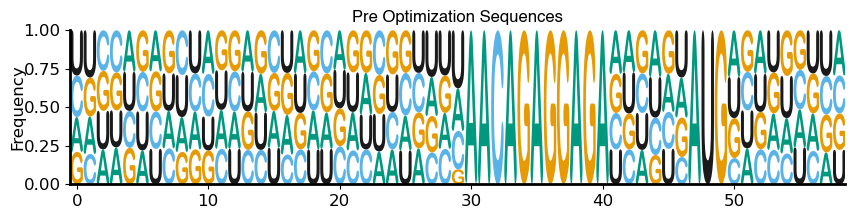

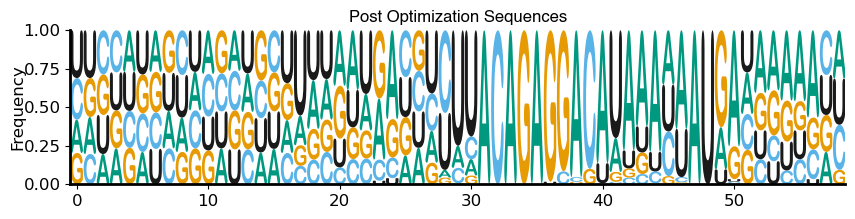

In [23]:

pre_seqs = util.one_hot_encode(df[['Pre_Optimized_Sequence']])
# high_ppms = GA_util.create_ppms_fast(high_seqs)


post_seqs = util.one_hot_encode(df[['Post_Optimized_Sequence']])
# low_ppms = GA_util.create_ppms_fast(low_seqs)

plt.rcParams.update({'font.size': 12})
plt.hfont = {'fontname':'Helvetica'}



util.plot_logo(pre_seqs,title='Pre Optimization Sequences')
# plt.savefig('../figures/trivial_act_max_pre_optimization_sequences')
util.plot_logo(post_seqs,title='Post Optimization Sequences')
# plt.savefig('../figures/trivial_act_max_optimized_sequences.png')

In [25]:
df.to_csv('../data/sequence_experiments/constrained_act_max.csv')